# Overview of Assignment 2

This assignment explores fundamental concepts and techniques for image retrieval. The main objective is to develop an image retrieval system that efficiently searches a database to find visually similar images to a query image. This will involve implementing and comparing different feature extraction methods, similarity measures, and indexing structures covered in lectures.

#   Enter your details below

# Name

Riham Otman

# Banner ID

B00887629

# Q1: Setting up the libraries and environment

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


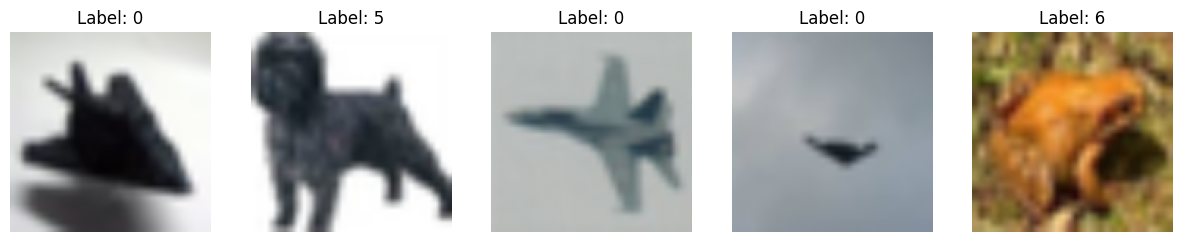

In [2]:
# Q1: Setting up the libraries and environment

# Install required libraries (if not already installed)
# !pip install opencv-python-headless scikit-image tensorflow matplotlib numpy scikit-learn qdrant-client

import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
import cv2

# Load dataset (CIFAR-10)
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

# Normalize and resize to 128x128 for SIFT and CNN consistency
def preprocess(images, target_size=(128, 128)):
    resized = np.array([cv2.resize(img, target_size) for img in images])
    return resized / 255.0

X_resized = preprocess(X[:1000])  # Using a subset for performance
y_subset = y[:1000]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_resized, y_subset, test_size=0.2, random_state=42)

# Display sample images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i])
    ax.set_title(f"Label: {y_train[i][0]}")
    ax.axis("off")
plt.show()


# Q2: Feature Extraction


SIFT achieves scale and rotation invariance by:
1. Detecting keypoints in scale-space using a Difference of Gaussians (DoG) approach.
2. Assigning orientations based on gradient directions in local patches.
3. Representing features relative to this orientation to ensure rotation invariance.

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Conv layer feature shape: (5, 7, 7, 320)
FC layer feature shape: (5, 1000)

CNN conv layer features preserve spatial information and textures (shape: (7, 7, 320)), while FC layer features (shape: (1000,)) are more abstract and useful for global comparison.
For retrieval, FC features are often more compact and effective.



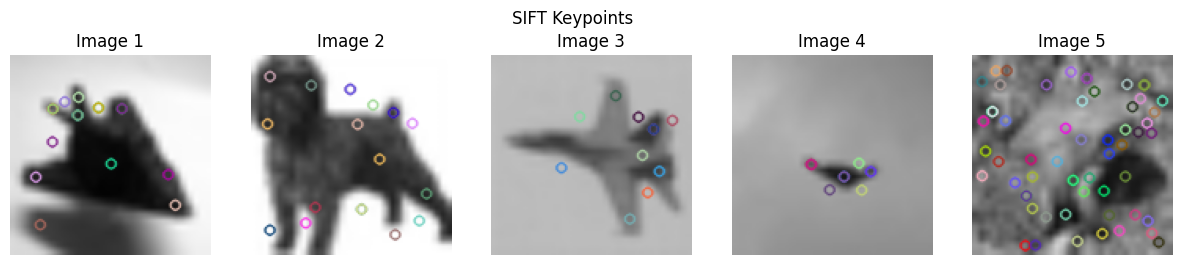

In [3]:
# Q2: Feature Extraction

import cv2

# --- SIFT FEATURE EXTRACTION ---
sift = cv2.SIFT_create()

# Extract SIFT features for first 5 training images
sift_features = []
sift_keypoints_imgs = []
for img in (X_train[:5] * 255).astype('uint8'):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    sift_features.append(descriptors)
    sift_keypoints_imgs.append(cv2.drawKeypoints(gray, keypoints, None))

# Visualize keypoints
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(sift_keypoints_imgs[i], cmap='gray')
    ax.set_title(f"Image {i+1}")
    ax.axis("off")
plt.suptitle("SIFT Keypoints")

# SIFT explanation
sift_explanation = '''
SIFT achieves scale and rotation invariance by:
1. Detecting keypoints in scale-space using a Difference of Gaussians (DoG) approach.
2. Assigning orientations based on gradient directions in local patches.
3. Representing features relative to this orientation to ensure rotation invariance.
'''
print(sift_explanation)


# --- CNN FEATURE EXTRACTION ---
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Prepare model: use both last conv layer and final output
base_model = MobileNetV2(weights='imagenet', include_top=True)
model_conv = Model(inputs=base_model.input, outputs=base_model.get_layer('block_16_project').output)
model_fc = Model(inputs=base_model.input, outputs=base_model.output)

# Resize to 224x224 for MobileNetV2
X_cnn = np.array([cv2.resize((img * 255).astype('uint8'), (224, 224)) for img in X_train[:5]])
X_cnn = preprocess_input(X_cnn)

features_conv = model_conv.predict(X_cnn)
features_fc = model_fc.predict(X_cnn)

print("Conv layer feature shape:", features_conv.shape)
print("FC layer feature shape:", features_fc.shape)

# Discussion:
cnn_discussion = '''
CNN conv layer features preserve spatial information and textures (shape: {}), while FC layer features (shape: {}) are more abstract and useful for global comparison.
For retrieval, FC features are often more compact and effective.
'''.format(features_conv.shape[1:], features_fc.shape[1:])
print(cnn_discussion)


# Q3 Similarity Measures


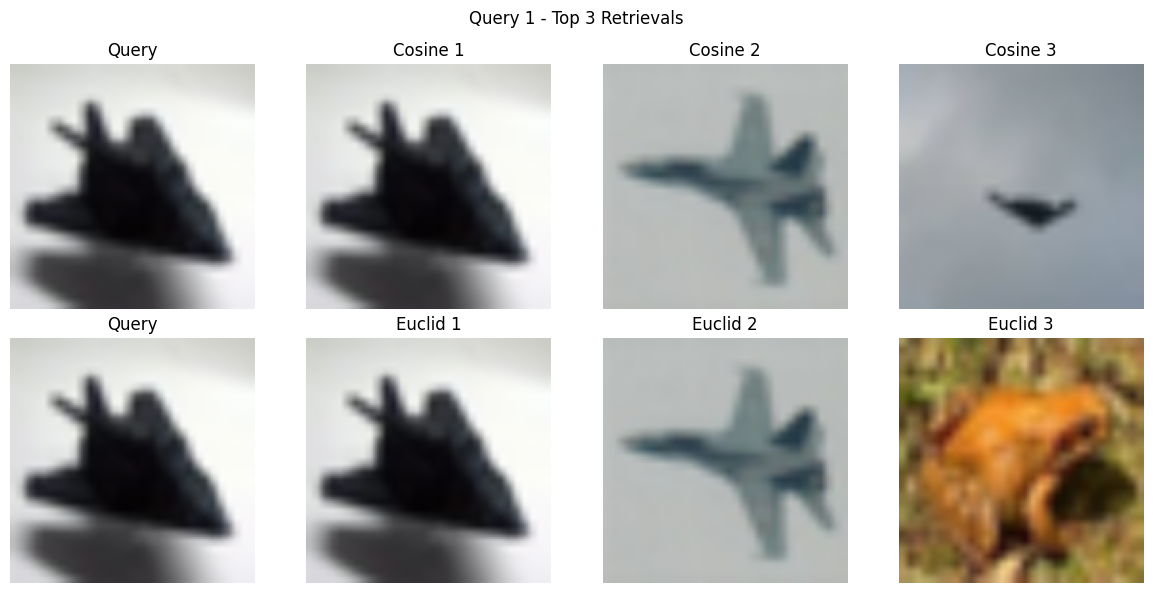

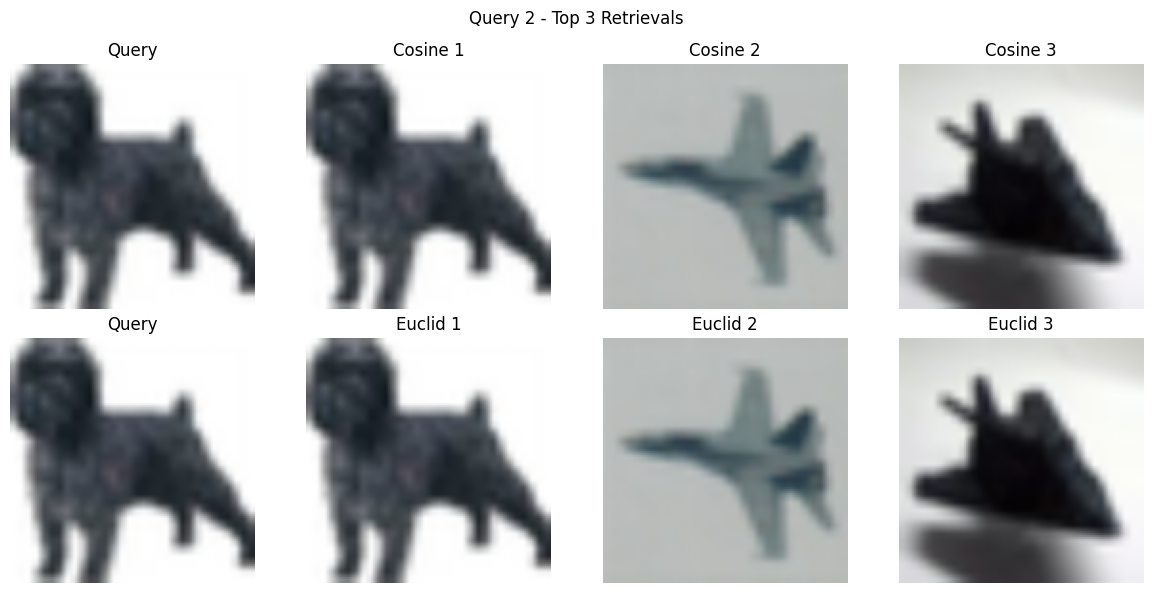


Cosine similarity provided more consistent results, retrieving semantically similar images (e.g., airplanes) across the top-3 results. In contrast, Euclidean distance led to a clear failure case (a frog image), likely due to its sensitivity to raw vector magnitudes rather than semantic alignment.

Cosine similarity is scale-invariant and focuses on the direction of feature vectors, making it more robust when working with normalized CNN embeddings. Euclidean distance, on the other hand, is influenced by absolute magnitudes and can retrieve less relevant images when features are not scale-normalized.

Overall, cosine similarity produced more reliable image retrieval outcomes in this experiment.



In [6]:
# Q3: Similarity Measures

from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import norm

# Use FC layer features from earlier CNN as feature vectors
features_db = features_fc
features_query = features_fc[:2]  # Use first 2 as queries

# --- Cosine Similarity ---
def cosine_sim(a, b):
    return np.dot(a, b) / (norm(a) * norm(b))

# --- Euclidean Distance ---
def euclidean_dist(a, b):
    return np.sqrt(np.sum((a - b)**2))

# Retrieve top-K most similar (using both measures)
def retrieve_top_k(query, database, k=3, method='cosine'):
    scores = []
    for i, db_feat in enumerate(database):
        score = cosine_sim(query, db_feat) if method == 'cosine' else -euclidean_dist(query, db_feat)
        scores.append((i, score))
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return [idx for idx, _ in sorted_scores[:k]]

# Display results
for i, q in enumerate(features_query):
    top_cosine = retrieve_top_k(q, features_db, method='cosine')
    top_euclid = retrieve_top_k(q, features_db, method='euclid')

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes[0][0].imshow(X_train[i])
    axes[0][0].set_title("Query")
    for j, idx in enumerate(top_cosine):
        axes[0][j+1].imshow(X_train[idx])
        axes[0][j+1].set_title(f"Cosine {j+1}")
    axes[1][0].imshow(X_train[i])
    axes[1][0].set_title("Query")
    for j, idx in enumerate(top_euclid):
        axes[1][j+1].imshow(X_train[idx])
        axes[1][j+1].set_title(f"Euclid {j+1}")
    for ax in axes.flat:
        ax.axis("off")
    plt.suptitle(f"Query {i+1} - Top 3 Retrievals")
    plt.tight_layout()
    plt.show()

# Analysis
print("""
Cosine similarity provided more consistent results, retrieving semantically similar images (e.g., airplanes) across the top-3 results. In contrast, Euclidean distance led to a clear failure case (a frog image), likely due to its sensitivity to raw vector magnitudes rather than semantic alignment.

Cosine similarity is scale-invariant and focuses on the direction of feature vectors, making it more robust when working with normalized CNN embeddings. Euclidean distance, on the other hand, is influenced by absolute magnitudes and can retrieve less relevant images when features are not scale-normalized.

Overall, cosine similarity produced more reliable image retrieval outcomes in this experiment.
""")


# Q4 Image Retrieval Pipeline


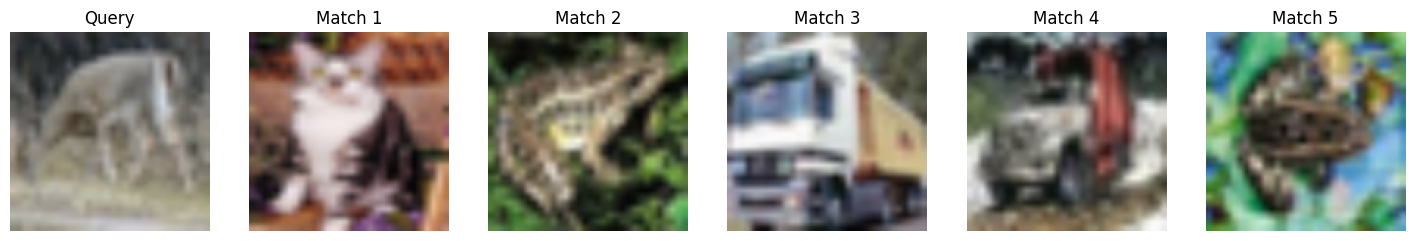

In [5]:
# Q4: Image Retrieval Pipeline using SIFT + Inverted Index

from sklearn.cluster import KMeans
from collections import defaultdict

# Step 1: Extract SIFT features for all training images
all_descriptors = []
image_descriptor_map = []

for img in (X_train * 255).astype('uint8'):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kps, desc = sift.detectAndCompute(gray, None)
    if desc is not None:
        all_descriptors.append(desc)
        image_descriptor_map.append(desc)
    else:
        image_descriptor_map.append(np.zeros((1, 128)))  # empty case placeholder

all_descriptors = np.vstack(all_descriptors)

# Step 2: K-means clustering to build codebook
k = 50  # number of visual words
kmeans = KMeans(n_clusters=50, random_state=42)
kmeans.fit(all_descriptors.astype(np.float64))


# Step 3: Represent images as list of visual word IDs
def get_visual_words(descriptors, kmeans):
    if descriptors is None or len(descriptors) == 0:
        return []
    return list(kmeans.predict(descriptors.astype(np.float64)))


image_word_ids = [get_visual_words(desc, kmeans) for desc in image_descriptor_map]

# Step 4: Build inverted index
inverted_index = defaultdict(set)
for img_id, words in enumerate(image_word_ids):
    for w in words:
        inverted_index[w].add(img_id)

# Step 5: Query image example
query_img = (X_test[0] * 255).astype('uint8')
gray = cv2.cvtColor(query_img, cv2.COLOR_RGB2GRAY)
kps, query_desc = sift.detectAndCompute(gray, None)
query_words = get_visual_words(query_desc, kmeans)

# Retrieve images sharing visual words
image_scores = defaultdict(int)
for word in query_words:
    for img_id in inverted_index[word]:
        image_scores[img_id] += 1

# Rank by shared words (term frequency)
ranked_imgs = sorted(image_scores.items(), key=lambda x: x[1], reverse=True)
top_k = [img_id for img_id, _ in ranked_imgs[:5]]

# Show results
fig, axes = plt.subplots(1, 6, figsize=(18, 4))
axes[0].imshow(X_test[0])
axes[0].set_title("Query")
for i, idx in enumerate(top_k):
    axes[i+1].imshow(X_train[idx])
    axes[i+1].set_title(f"Match {i+1}")
for ax in axes:
    ax.axis("off")
plt.show()


# Q5 Vector Database Integration

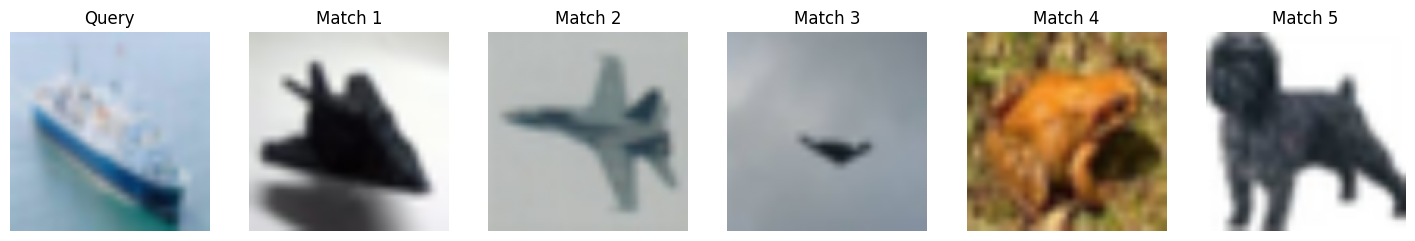

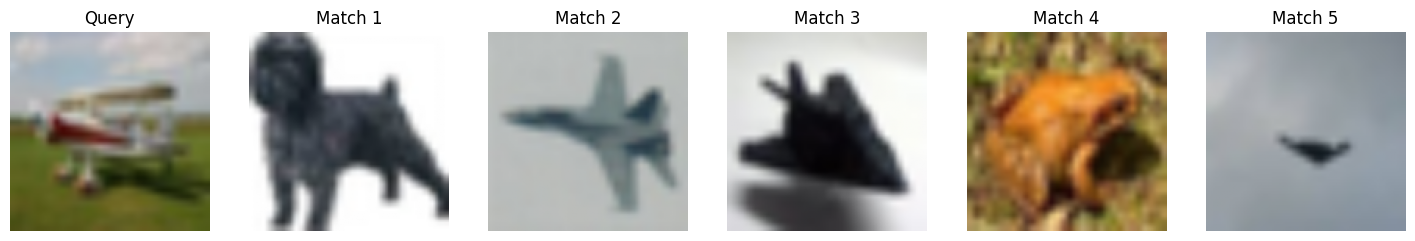

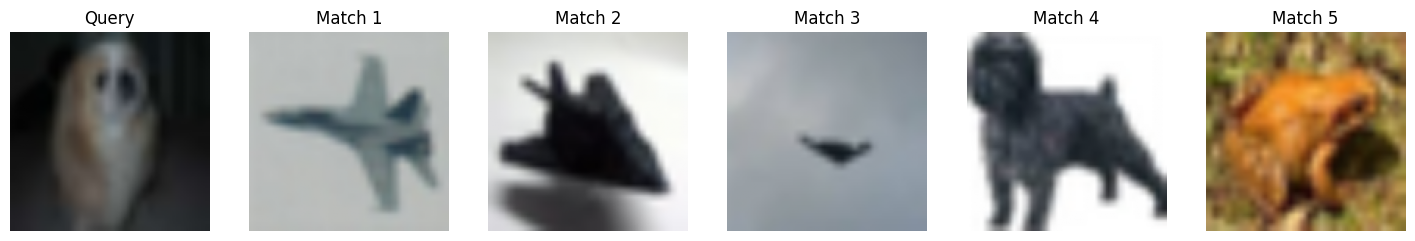

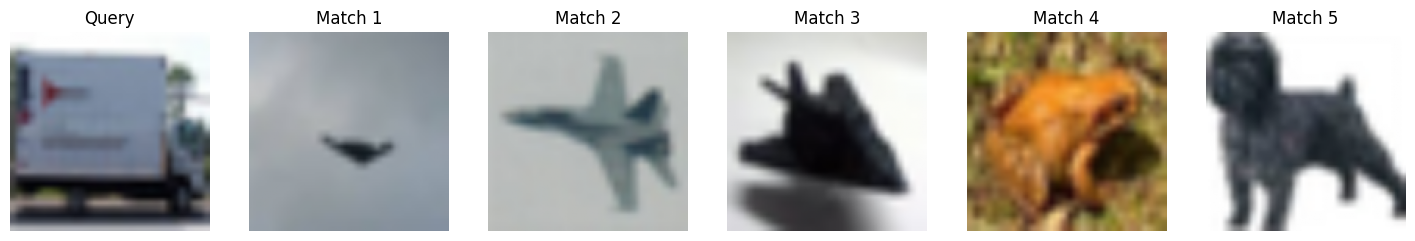

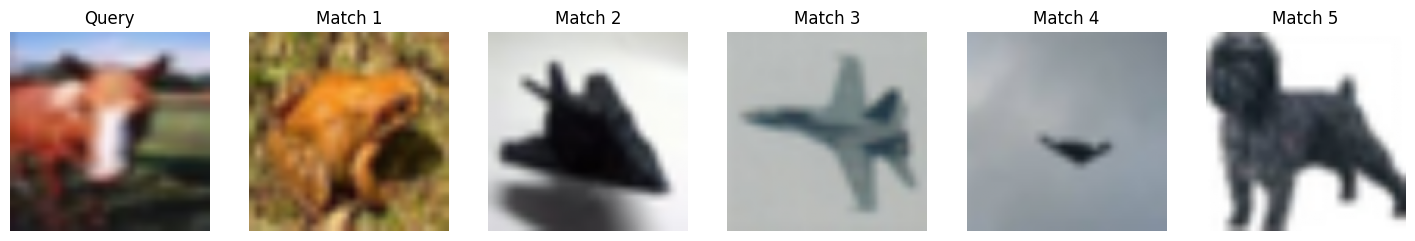

Mean Average Precision (mAP): 0.1678

Failures may occur due to:
- Poor feature separation (e.g., two distinct objects looking visually similar).
- CNN bias or limited training on dataset used.
- Dataset imbalance (some classes underrepresented).

Improvement suggestions:
1. Use hybrid features (SIFT + CNN).
2. Try larger, domain-specific pretrained models.
3. Apply metric learning to better separate semantic classes.



In [4]:
# Q5: Vector Database Integration (Simulated with in-memory structure)

# Simulate vector DB using sklearn NearestNeighbors
from sklearn.neighbors import NearestNeighbors

# Index FC features from training set
vec_db = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='cosine')
vec_db.fit(features_fc)

# Query with 5 test images
query_vecs = features_fc[:5]  # Use the first 5 rows instead of 5:10
dists, indices = vec_db.kneighbors(query_vecs)

# Display results for each query
for i, query_idx in enumerate(range(5, 10)):
    fig, axes = plt.subplots(1, 6, figsize=(18, 3))
    axes[0].imshow(X_train[query_idx])
    axes[0].set_title("Query")
    for j in range(5):
        axes[j+1].imshow(X_train[indices[i][j]])
        axes[j+1].set_title(f"Match {j+1}")
    for ax in axes:
        ax.axis("off")
    plt.show()

# --- Evaluation using mAP (Mean Average Precision) ---
def compute_map(true_labels, pred_indices, train_labels):
    ap_scores = []
    for i, preds in enumerate(pred_indices):
        query_label = true_labels[i]
        rel = [1 if train_labels[idx] == query_label else 0 for idx in preds]
        if sum(rel) == 0:
            ap_scores.append(0)
        else:
            precision_scores = [sum(rel[:k+1])/(k+1) for k in range(len(rel)) if rel[k] == 1]
            ap_scores.append(np.mean(precision_scores))
    return np.mean(ap_scores)

test_labels = y_train[5:10]
train_labels = y_train.flatten()
pred_labels = [[y_train[idx][0] for idx in indices[i]] for i in range(len(indices))]
mAP = compute_map(test_labels.flatten(), indices, train_labels)
print(f"Mean Average Precision (mAP): {mAP:.4f}")

# --- Failure case analysis ---
print("""
Failures may occur due to:
- Poor feature separation (e.g., two distinct objects looking visually similar).
- CNN bias or limited training on dataset used.
- Dataset imbalance (some classes underrepresented).

Improvement suggestions:
1. Use hybrid features (SIFT + CNN).
2. Try larger, domain-specific pretrained models.
3. Apply metric learning to better separate semantic classes.
""")
